In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 594
Total videos for testing: 224


In [ ]:
train_df.sample(10)

video_name           tag
528   v_TennisSwing_g15_c04.avi   TennisSwing
257         v_Punch_g10_c06.avi         Punch
143  v_PlayingCello_g11_c06.avi  PlayingCello
102   v_CricketShot_g23_c04.avi   CricketShot
497   v_TennisSwing_g11_c01.avi   TennisSwing
402  v_ShavingBeard_g15_c01.avi  ShavingBeard
525   v_TennisSwing_g15_c01.avi   TennisSwing
9     v_CricketShot_g09_c03.avi   CricketShot
591   v_TennisSwing_g25_c04.avi   TennisSwing
349         v_Punch_g24_c05.avi         Punch

In [ ]:
def crop_center_square(frame):
        y, x = frame.shape[0:2]
        min_dim = min(y, x)
        start_x = (x // 2) - (min_dim // 2)
        start_y = (y // 2) - (min_dim // 2)
        return frame[start_y : start_y+min_dim, start_x : start_x+min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(weights="imagenet",
                                                       include_top=False, pooling="avg",
                                                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES),   dtype="float32")
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH, ), dtype="bool")
        temp_frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES),dtype="float32")
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
            temp_frame_mask[i, :length] = 1

        frame_features[idx, ] = temp_frame_featutes.squeeze()
        frame_masks[idx, ] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [ ]:
train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(loss="sparse_categorical_crossentropy",
        optimizer="adam", metrics=["accuracy"])
    return rnn_model
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True,
                                 save_best_only=True, verbose=1)
    seq_model = get_sequence_model()
    history = seq_model.fit([train_data[0], train_data[1]], train_labels,
        validation_split=0.3, epochs=EPOCHS, callbacks=[checkpoint])

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [ ]:
_, sequence_model = run_experiment()


Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.4256 - accuracy: 0.3060
Epoch 1: val_loss improved from inf to 2.41217, saving model to /tmp/video_classifier
13/13 [==============================] - 13s 258ms/step - loss: 1.4256 - accuracy: 0.3060 - val_loss: 2.4122 - val_accuracy: 0.0000e+00
Epoch 2/10
11/13 [========================>.....] - ETA: 0s - loss: 1.2991 - accuracy: 0.3409
Epoch 2: val_loss did not improve from 2.41217
13/13 [==============================] - 0s 19ms/step - loss: 1.2797 - accuracy: 0.3783 - val_loss: 2.5262 - val_accuracy: 0.0000e+00
Epoch 3/10
11/13 [========================>.....] - ETA: 0s - loss: 1.1852 - accuracy: 0.5000
Epoch 3: val_loss did not improve from 2.41217
13/13 [==============================] - 0s 17ms/step - loss: 1.1808 - accuracy: 0.5036 - val_loss: 2.7881 - val_accuracy: 0.0000e+00
Epoch 4/10
10/13 [======================>.......] - ETA: 0s - loss: 1.1211 - accuracy: 0.5437
Epoch 4: val_loss did not improve from 2

#testing the data

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH, ), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES),
                            dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1

    return frame_featutes, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()
    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Test video path: v_TennisSwing_g03_c01.avi
1/1 [==============================] - 2s 2s/step
  CricketShot: 36.92%
  Punch: 31.65%
  ShavingBeard: 22.38%
  TennisSwing:  5.13%
  PlayingCello:  3.92%



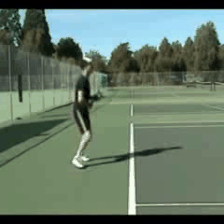

In [ ]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])
